In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
download_data = True

if download_data:
    
    data, info = tfds.load('mnist', with_info=True, data_dir='./data')

else:
        
    data, info = tfds.load('mnist', with_info=True, download=False, data_dir='./data')

Instructions for updating:
Colocations handled automatically by placer.


W0604 17:44:16.898061 140371278567168 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [3]:
train_data = tfds.as_numpy(data['train'])
test_data = tfds.as_numpy(data['test'])

In [4]:
X = []
y = []

for digit in train_data:
    
    X.append(digit['image'])
    y.append(digit['label'])       

X = np.array(X)/255
y = np.array(y)

y = to_categorical(y)

In [5]:
X_test = []
y_test = []

for digit in test_data:
    
    X_test.append(digit['image'])
    y_test.append(digit['label'])       

X_test = np.array(X_test)/255
y_test = np.array(y_test)

y_test = to_categorical(y_test)

In [6]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=0)

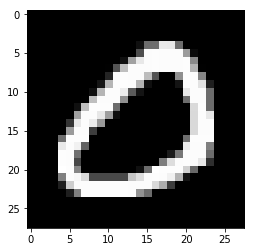

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
i = 10
plt.gray()
plt.imshow(X_train[i].reshape(28,28), interpolation='none')
plt.show()

print(y_train[i])


## The First Model

In [8]:
model = Sequential()

model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                310       
Total para

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
first_model_output = model.fit(X_train, y_train, epochs=20, validation_data=(X_validate, y_validate))
first_model = model

Instructions for updating:
Use tf.cast instead.


W0604 17:44:45.154139 140371278567168 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 5s 100us/step - loss: 0.4123 - acc: 0.8724 - val_loss: 0.2408 - val_acc: 0.9257
Epoch 2/20
51000/51000 [==============================] - 4s 83us/step - loss: 0.1863 - acc: 0.9435 - val_loss: 0.1633 - val_acc: 0.9522
Epoch 3/20
51000/51000 [==============================] - 4s 83us/step - loss: 0.1425 - acc: 0.9570 - val_loss: 0.1574 - val_acc: 0.9544
Epoch 4/20
51000/51000 [==============================] - 4s 86us/step - loss: 0.1208 - acc: 0.9631 - val_loss: 0.1398 - val_acc: 0.9573
Epoch 5/20
51000/51000 [==============================] - 4s 82us/step - loss: 0.1058 - acc: 0.9686 - val_loss: 0.1318 - val_acc: 0.9608
Epoch 6/20
51000/51000 [==============================] - 4s 83us/step - loss: 0.0939 - acc: 0.9713 - val_loss: 0.1260 - val_acc: 0.9616
Epoch 7/20
51000/51000 [==============================] - 4s 85us/step - loss: 0.0861 - acc: 0.9734 - val_loss: 0.1243 - val_acc

In [12]:
metrics = pd.DataFrame(first_model_output.history)

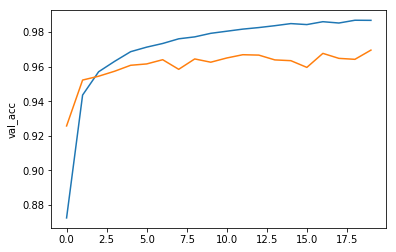

In [13]:
sns.lineplot(data=metrics, x = metrics.index, y='acc')
sns.lineplot(data=metrics, x = metrics.index, y='val_acc')

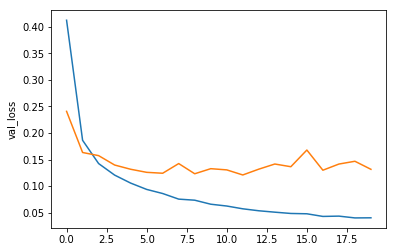

In [14]:
sns.lineplot(data=metrics, x = metrics.index, y='loss')
sns.lineplot(data=metrics, x = metrics.index, y='val_loss')

In [15]:
predictions = first_model.predict(X_test)

In [16]:
predictions = [np.argmax(x) for x in predictions]

In [17]:
first_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 30us/step


[0.1350097609926015, 0.9691]

## CNN Model

In [18]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))

model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(60, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0604 17:46:18.601220 140371278567168 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 60)          9660      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 60)          0         
__________

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
output = model.fit(X_train, y_train, epochs=20,  validation_data=(X_validate, y_validate))
second_model = model

Train on 51000 samples, validate on 9000 samples
Epoch 1/20
51000/51000 [==============================] - 47s 920us/step - loss: 0.2931 - acc: 0.9069 - val_loss: 0.0962 - val_acc: 0.9718
Epoch 2/20
51000/51000 [==============================] - 45s 890us/step - loss: 0.0965 - acc: 0.9701 - val_loss: 0.0732 - val_acc: 0.9774
Epoch 3/20
51000/51000 [==============================] - 46s 903us/step - loss: 0.0748 - acc: 0.9770 - val_loss: 0.0659 - val_acc: 0.9788
Epoch 4/20
51000/51000 [==============================] - 46s 893us/step - loss: 0.0602 - acc: 0.9806 - val_loss: 0.0418 - val_acc: 0.9872
Epoch 5/20
51000/51000 [==============================] - 46s 895us/step - loss: 0.0537 - acc: 0.9838 - val_loss: 0.0420 - val_acc: 0.9880
Epoch 6/20
51000/51000 [==============================] - 45s 890us/step - loss: 0.0480 - acc: 0.9852 - val_loss: 0.0429 - val_acc: 0.9879
Epoch 7/20
51000/51000 [==============================] - 46s 900us/step - loss: 0.0451 - acc: 0.9859 - val_loss: 0.0

In [22]:
predictions = second_model.predict(X_test)

In [23]:
predictions = [np.argmax(x) for x in predictions]

In [24]:
second_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 327us/step


[0.023139943968826265, 0.9944]